<a href="https://colab.research.google.com/github/Dyl4No1/BigDataProject/blob/main/Assignment_2_19703357.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# get spark up and running (do this once when you restart a colab session or it times out)

# first, install the jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# get spark itself
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz

# unzip spark
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# install findspark so colab notebook sees it
!pip install -q findspark

# and setup env variable so pyspark works
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# for using spark UI in colab... this allows tunnel to the UI
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

import findspark
findspark.init()

--2023-01-23 23:28:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 18.205.222.128, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  13.8MB/s    in 1.0s    

2023-01-23 23:28:44 (13.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
#make spark ui work in colab

get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels
spark

{"tunnels":[],"uri":"/api/tunnels"}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pyspark

from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import *
from sklearn.model_selection import train_test_split
from pyspark.ml.classification import DecisionTreeClassifier,LinearSVC, MultilayerPerceptronClassifier;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

# **Task1.1:**
# Data Cleaning

In [ ]:
smlNucplant = spark.read.csv("nuclear_plants_small_dataset.csv",  inferSchema=True,header=True)

print("top 10 entries of smlNucplant: ")
smlNucplant.show(10)

print("--------------")
print("schema: ")
smlNucplant.printSchema()

print("full headings: ")
smlNucplant.head()

top 10 entries of smlNucplant: 
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|    

Row(Status='Normal', Power_range_sensor_1=4.5044, Power_range_sensor_2=0.7443, Power_range_sensor_3 =6.34, Power_range_sensor_4=1.9052, Pressure _sensor_1=29.5315, Pressure _sensor_2=0.8647, Pressure _sensor_3=2.2044, Pressure _sensor_4=6.048, Vibration_sensor_1=14.4659, Vibration_sensor_2=21.648, Vibration_sensor_3=15.3429, Vibration_sensor_4=1.2186)

Searching for Null values in the dataset:

In [ ]:
nuclearTemp = smlNucplant.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in smlNucplant.columns])
nuclearTemp.show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     0|                   0|                   0|                    0|                   0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
+------+--------

1.2
split by normal and abnormal

In [ ]:
## split by Status values
nrmDf = smlNucplant.filter(smlNucplant['status'] == 'Normal')
nrmDf.show(5)

abnrmDf = smlNucplant.filter(smlNucplant['status'] == 'Abnormal')
abnrmDf.show(5)

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

Normal

In [ ]:
## nrmDf minimum, maximum, mean and median values
tempDf = nrmDf.toPandas()
nrmStat = tempDf.describe().loc[['min','max','mean','50%']]
#could do: 
# df.summary("min","max","mean","50%").show()
#for pyspark dataframe

print(nrmStat)

      Power_range_sensor_1  Power_range_sensor_2  Power_range_sensor_3   \
min               0.085100              0.040300               4.382600   
max              12.129800             11.928400              14.098200   
mean              5.602453              6.844503               9.292054   
50%               5.178650              6.717650               9.262850   

      Power_range_sensor_4  Pressure _sensor_1  Pressure _sensor_2  \
min               0.154700            0.024800            0.010400   
max              16.356800           56.856200            9.221200   
mean              8.701398           13.797526            3.415646   
50%               9.240850           10.634800            3.113000   

      Pressure _sensor_3  Pressure _sensor_4  Vibration_sensor_1  \
min             0.077400             0.00580            0.009200   
max            12.647500            15.10850           31.498100   
mean            5.923353             5.58618            8.441437   
5

# **Normal Group Boxplots**

Text(0, 0.5, 'Values')

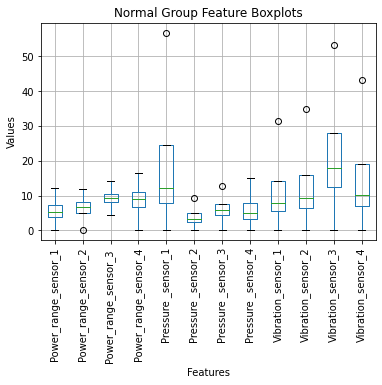

In [ ]:
#normal group first features
nrmStat.boxplot(column=['Power_range_sensor_1', 'Power_range_sensor_2', 'Power_range_sensor_3 ',  'Power_range_sensor_4', \
                       'Pressure _sensor_1','Pressure _sensor_2', 'Pressure _sensor_3' ,'Pressure _sensor_4', \
                       'Vibration_sensor_1', 'Vibration_sensor_2', 'Vibration_sensor_3', 'Vibration_sensor_4'], fontsize=10, rot=90)

##
plt.title('Normal Group Feature Boxplots')
plt.xlabel('Features')
plt.ylabel('Values')
##

Abnormal

In [ ]:
## nrmDf minimum, maximum, mean and median values
tempDf = abnrmDf.toPandas()
abnrmStat = tempDf.describe().loc[['min','max','mean','50%']]
print(abnrmStat)

      Power_range_sensor_1  Power_range_sensor_2  Power_range_sensor_3   \
min               0.008200              0.389100               2.583966   
max              10.923078             10.154100              15.759900   
mean              4.396695              5.914043               9.164170   
50%               4.513550              5.932218               9.472050   

      Power_range_sensor_4  Pressure _sensor_1  Pressure _sensor_2  \
min               0.062300            0.131478            0.008262   
max              17.235858           67.979400           10.242738   
mean              6.009146           14.600728            2.740270   
50%               5.399300           12.596150            2.382689   

      Pressure _sensor_3  Pressure _sensor_4  Vibration_sensor_1  \
min             0.001224            0.029478            0.000000   
max            11.772400           16.555620           36.186438   
mean            5.575115            4.407824            7.887689   
5

# **Abnormal Group Boxplots**

Text(0, 0.5, 'Values')

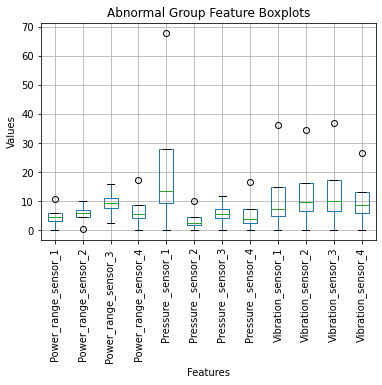

In [ ]:
#abnormal group features
abnrmStat.boxplot(column=['Power_range_sensor_1', 'Power_range_sensor_2', 'Power_range_sensor_3 ',  'Power_range_sensor_4', \
                       'Pressure _sensor_1','Pressure _sensor_2', 'Pressure _sensor_3' ,'Pressure _sensor_4', \
                       'Vibration_sensor_1', 'Vibration_sensor_2', 'Vibration_sensor_3', 'Vibration_sensor_4'], fontsize=10, rot=90)
##
plt.title('Abnormal Group Feature Boxplots')
plt.xlabel('Features')
plt.ylabel('Values')
##

#**Task1.3 Correlation matrix**

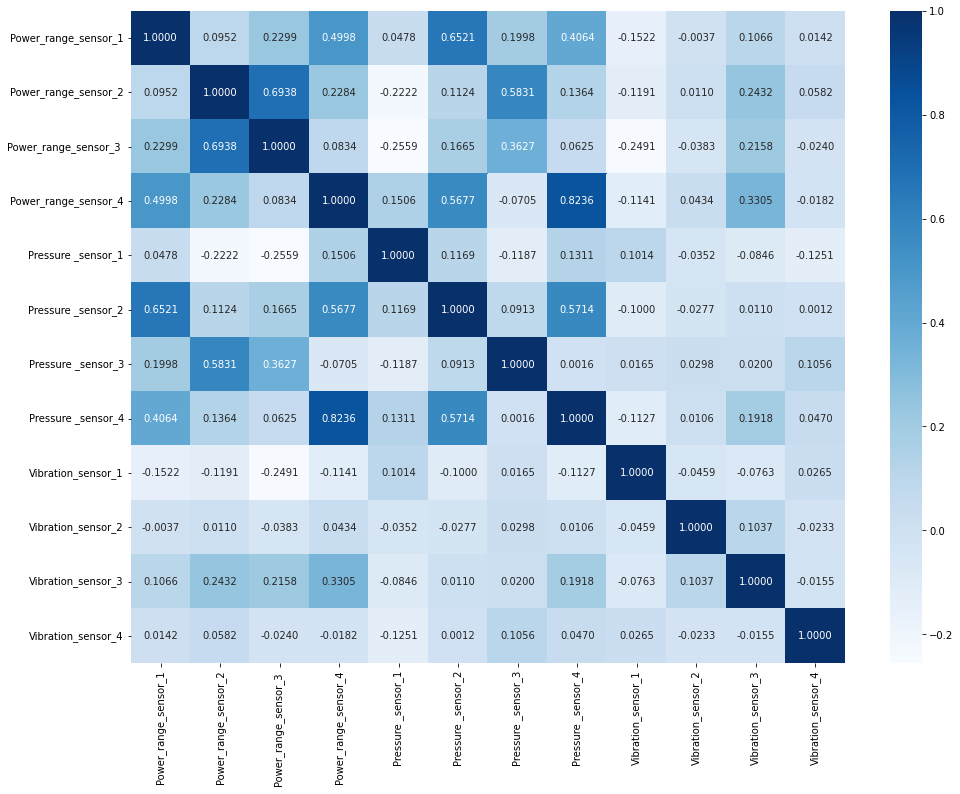

In [ ]:
# correlation matrix, with corr coefficient of two features
smlNucplant.drop('Status')
matrixDf = smlNucplant.toPandas()

# create correlation matrix for matrixDf
corrMatrix = matrixDf.corr(method='pearson')

#make the below heatmap bigger
plt.figure(figsize=(16,12))
#seaborn heatmap (to make it look nice)
sb.heatmap(corrMatrix, annot=True, annot_kws={"size": 10}, cmap="Blues", fmt=".4f")

#**Task1.4 Split and Shuffle**

In [ ]:
## transforming the whole dataset into a vector for machine learning aspects

assembler = VectorAssembler(
    inputCols=['Power_range_sensor_1', 'Power_range_sensor_2', 'Power_range_sensor_3 ',  'Power_range_sensor_4', \
                       'Pressure _sensor_1','Pressure _sensor_2', 'Pressure _sensor_3' ,'Pressure _sensor_4', \
                       'Vibration_sensor_1', 'Vibration_sensor_2', 'Vibration_sensor_3', 'Vibration_sensor_4'],
    outputCol="features")

vecOutput = assembler.transform(smlNucplant)
vecOutput.show(10)

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|            features|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|           

In [ ]:
## creating labelIndexer with stringindexer
labelIndexer = StringIndexer(inputCol="Status", outputCol="labelIndex")

dataIndexed = labelIndexer.fit(vecOutput).transform(vecOutput)

In [ ]:
#train test split 70%:30%
randOrder = dataIndexed.orderBy(rand())

##assign train and test sets by shuffled order
[randSplitTraining, randSplitTesting] = randOrder.randomSplit([0.7,0.3], seed=1234)

print(randSplitTraining.count())
print(randSplitTesting.count())

701
295


#**Task1.5 Decision Tree, SVM and ANN**

In [ ]:
def funcConfMatrix (funcInput ):
  
  # evaluate
  evaluator = MulticlassClassificationEvaluator(labelCol = "labelIndex",\
                                                predictionCol = "prediction",\
                                                metricName = "accuracy")
  funcAcc = evaluator.evaluate(funcInput)
    
  # set variables for confusion matrix
  CMPred= funcInput.select("prediction").collect()
  CMOrig= funcInput.select("labelIndex").collect()

  # create and print confusion matrix
  confusionMatrix = confusion_matrix(CMOrig, CMPred)
  print("Confusion Matrix: ", "\n", confusionMatrix, "\n")

  # Map for analysis variables
  tp = confusionMatrix[0][0]
  fp = confusionMatrix[1][0]
  fn = confusionMatrix[0][1]
  tn = confusionMatrix[1][1]



  # print preparation
  errorRate = 1 - ((tp+tn) /(tp+fp+tn+fn))
  sensitivityRate = tp / (tp+fn)
  specificity = tn / (tn + fp)

  # function output
  print("pred accuracy: ", funcAcc, "\n---------------------------------")
  print("\n Error Rate (to 5d.p.): ", errorRate.round(5))
  print("\n Sensitivity (to 5d.p.): ", sensitivityRate.round(5))
  print("\n Specificity (to 5d.p.): ", specificity.round(5))

Decision Tree

In [ ]:
# define classifier and fit tree
decisionTree = DecisionTreeClassifier(labelCol = "labelIndex", featuresCol = "features")
dTreeTrain = decisionTree.fit(randSplitTraining)

# set predictions for Correlation Matrix function
dTreePred = dTreeTrain.transform(randSplitTesting)

#Call Conf Matrix Function
funcConfMatrix(dTreePred)

Confusion Matrix:  
 [[132  27]
 [ 15 121]] 

pred accuracy:  0.8576271186440678 
---------------------------------

 Error Rate (to 5d.p.):  0.14237

 Sensitivity (to 5d.p.):  0.83019

 Specificity (to 5d.p.):  0.88971


Support Vector Machine

In [ ]:
## define model and create train dataset
svm = LinearSVC(labelCol = "labelIndex", featuresCol = "features", maxIter=100)
svmTrain = svm.fit(randSplitTraining)

# make dataset fit andcomply with fucntion requirements
svmPred = svm.fit(randSplitTesting).transform(randSplitTesting)

# Call Conf Matrix function
funcConfMatrix(svmPred)


Confusion Matrix:  
 [[125  34]
 [ 28 108]] 

pred accuracy:  0.7898305084745763 
---------------------------------

 Error Rate (to 5d.p.):  0.21017

 Sensitivity (to 5d.p.):  0.78616

 Specificity (to 5d.p.):  0.79412


Artificial Neural Network

In [ ]:
# definte model and fit training dataset
mlp = MultilayerPerceptronClassifier(labelCol = "labelIndex", featuresCol = "features", maxIter=100, layers=[12, 6, 6, 2], seed=1234)
mlpModel = mlp.fit(randSplitTraining)

# make dataset fit andcomply with fucntion requirements
mlpPred = mlp.fit(randSplitTesting).transform(randSplitTesting)

# call Conf Matrix function
funcConfMatrix(mlpPred)

Confusion Matrix:  
 [[140  19]
 [ 36 100]] 

pred accuracy:  0.8135593220338984 
---------------------------------

 Error Rate (to 5d.p.):  0.18644

 Sensitivity (to 5d.p.):  0.8805

 Specificity (to 5d.p.):  0.73529


# **Task 2 - MapReduce for Margie Travel dataset**

Write a Python code, must use MapReduce in Pyspark, to accomplish the following:

2.1-	Determine the number of flights from each airport; include a list of any airports not used.

2.2-	Create a list of flights based on the Flight id, this output should include number of passengers, relevant IATA/FAA codes, and departure and arrival times (times converted to HH:MM format).

2.3-	Calculate the line-of-sight (nautical) miles for each flight and the total travelled by each passenger and thus output the passenger having earned the highest air miles.


- **AComp_Passenger_data.csv**: there are various errors in this data file, which illustrate a range of potential errors that could occur when handling large scale data from multiple, sometimes unreliable, sources. It is not necessary to handle this file and address these errors in your application. This file is instead provided to highlight the requirement of error handling in MapReduce applications.
- **AComp_Passenger_data_no_error_DateTime.csv**: it may use to convert date/time data from Unix epoch time to a human readable format for use when debugging and for validation purposes.


2.1

In [ ]:
spark.sparkContext.stop()
conf = pyspark.SparkConf().setAppName("MapReduce").setMaster("local")
sc = pyspark.SparkContext(conf = conf)

In [ ]:
def notIncluded(x):
  # print(x)
  ## map builds recursively return x if not in departures
  if x not in listReduced_pD:
    return x
  else:
    pass
      

In [ ]:
#########
## 2.1 ##	Determine the number of flights from each airport; include a list of any airports not used.
#########

## create list of headers for pandas dataframe
columns1 = ['PassengerID', 'FlightID', 'fromAirport', 'toAirport', 'timeOfDeparture', 'flightTime']
columns2 = ['airportName', 'airportCode', 'Latitude', 'Longitude']
## apply columns variables for heading in pd dataframes
passengerData = pd.read_csv("AComp_Passenger_data_no_error.csv", encoding = 'latin1', names = columns1)
airportCoords = pd.read_csv("Top30_airports_LatLong.csv", encoding = 'latin1', names = columns2)

## list comprehension for datasets
uniqueFlights = [x for x in passengerData['FlightID']]
dep_airportCodes = [y for y in passengerData['fromAirport']]
arr_airportCodes = [i for i in passengerData['toAirport']]
top30 = [x for x in airportCoords['airportCode']]

## convert dataframe to list:
list_passengerData = passengerData.values.tolist()
rdd_pD = sc.parallelize(list_passengerData)

## take 2 columns and count
passMapped_pD = rdd_pD.map( lambda x : ((x[1], x[2]), 1 ))

## reduce to collate data entries to find count of occurences
reduced_pD = passMapped_pD.reduceByKey(lambda x1, x2 : x1 + x2)

##  to be ued later with func call
top30_rDD = sc.parallelize(top30)

## map to get each flight, then reduce to merge counts
airportMapped_pD = reduced_pD.map(lambda x : (x[0][1], 1))
airportReduced_pD = airportMapped_pD.reduceByKey(lambda x1, x2 : x1 + x2)

## create list for comparison of included coordinates
listReduced_pD = [x[0] for x in airportReduced_pD.collect()] ## to be used in function 

## map of function call, all codes in dataset = None, filter != None values
airportNotused = top30_rDD.map(notIncluded)
airportReducedAgain = airportNotused.filter(lambda x: x != None)

## final result:
for i in airportReduced_pD.collect():
  ## output airport count
  print(f'Airport {i[0]} has appeared {i[1]} times')
## output flights not included
print(f'Below is a list of airports that have no flights: \n{airportReducedAgain.collect()}')

Airport DEN has appeared 3 times
Airport JFK has appeared 1 times
Airport ORD has appeared 2 times
Airport KUL has appeared 2 times
Airport MAD has appeared 1 times
Airport LHR has appeared 1 times
Airport CGK has appeared 2 times
Airport MUC has appeared 1 times
Airport AMS has appeared 1 times
Airport DFW has appeared 1 times
Airport MIA has appeared 1 times
Airport CDG has appeared 1 times
Airport CAN has appeared 2 times
Airport IAH has appeared 2 times
Airport LAS has appeared 1 times
Airport CLT has appeared 1 times
Airport ATL has appeared 2 times
Airport PVG has appeared 1 times
Airport FCO has appeared 1 times
Airport BKK has appeared 1 times
Airport PEK has appeared 1 times
Airport HND has appeared 1 times
Below is a list of airports that have no flights: 
['LAX', 'FRA', 'HKG', 'DXB', 'SIN', 'SFO', 'PHX', 'IST']


In [ ]:
from datetime import datetime, timedelta
def convertTime (x):

  ## convert unix Epoch to utc standard time
  if len(str(x))  > 4:  #unix epoch code
    return datetime.utcfromtimestamp(x).strftime('%H:%M')

def convertTimeDelta (x, y):

  ## timedelta to find out arrival time
  return (datetime.utcfromtimestamp(x) + timedelta(minutes = y)).strftime('%H:%M')

In [ ]:
#########
## 2.2 ##	Create a list of flights based on the Flight id, this output should include number of passengers,
######### relevant IATA/FAA codes, and departure and arrival times (times converted to HH:MM format).

## unix epoch time
passengerDep_dT = passengerData['timeOfDeparture']
## time in minutes
passengerDep_fT = passengerData['flightTime']

## map by columns, with count outside of tuple.
task2 = rdd_pD.map(lambda x : ( (x[1], x[2], x[3], convertTime(x[4]), convertTimeDelta(x[4],x[5])), 1) )
## reduce to group all similar entries; increasing count
task2Reduced = task2.reduceByKey(lambda x1 , x2 : x1 + x2)

## final result: 
for i in task2Reduced.collect():
  #print(i)      ## for raw output
  print(f'Flight {i[0][0]} departs from {i[0][1]} at {i[0][3]}, arriving at {i[0][2]} at {i[0][4]}, with {i[1]} passengers.')

Flight SQU6245R departs from DEN at 17:14, arriving at FRA at 10:43, with 21 passengers.
Flight XXQ4064B departs from JFK at 17:05, arriving at FRA at 06:27, with 25 passengers.
Flight SOH3431A departs from ORD at 17:00, arriving at MIA at 21:10, with 18 passengers.
Flight PME8178S departs from DEN at 17:13, arriving at PEK at 15:15, with 18 passengers.
Flight MBA8071P departs from KUL at 17:04, arriving at PEK at 02:36, with 16 passengers.
Flight MOO1786A departs from MAD at 16:56, arriving at FRA at 20:00, with 13 passengers.
Flight HUR0974O departs from DEN at 17:15, arriving at PVG at 16:33, with 7 passengers.
Flight GMO5938W departs from LHR at 17:11, arriving at PEK at 10:48, with 25 passengers.
Flight DAU2617A departs from CGK at 17:23, arriving at SFO at 23:34, with 12 passengers.
Flight RUM0422W departs from MUC at 16:58, arriving at MAD at 20:12, with 14 passengers.
Flight ATT7791R departs from AMS at 17:13, arriving at DEN at 09:54, with 15 passengers.
Flight WPW9201U depart

In [ ]:
from math import radians, cos, sin, asin, sqrt
def Haversine(lat1, lon1, lat2, lon2):

  ## convert inputs to radians
  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  ## find differences betweeen inputs
  dlon = lon2 - lon1
  dlat = lat2 - lat1

  ## haversine formula implementation:
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a)) 
  ## radius of earth to 10 decimal places (nautical miles)
  r = 3443.9308855292

  return c * r

In [ ]:
def getCoords(depCode, arrCode, listDict):
  ## 4. map into a "code to lat long function " which checks the dictionary for the codes inputtted ##

  ## where key depCode/arrCode, make list of values from dict
  departLatLong = next(i[depCode] for i in listDict if depCode in i)
  arrivalLatLong = next(i[arrCode] for i in listDict if arrCode in i)

  ## return function call for values fed iteratively through getCoords function
  return Haversine(departLatLong[0], departLatLong[1], arrivalLatLong[0], arrivalLatLong[1])

In [ ]:
#########
## 2.3 ##	Calculate the line-of-sight (nautical) miles for each flight and the total travelled by each passenger 
######### and thus output the passenger having earned the highest air miles.

## top30 dataset to list, then rdd
listTop30 = airportCoords.values.tolist()
rddTop30 = sc.parallelize(listTop30)

## map coordinates, turns into dictionary
dictionaryMap = rddTop30.map(lambda x : ( {x[1]: (x[2], x[3])} ))
## turn dictionary into list
listDict = dictionaryMap.collect()

## create separate map for pass IDs and IATA codes
mapPDA = rdd_pD.map(lambda x : (x[0], x[2], x[3]))

## collate workings into a map
anotherMap = mapPDA.map(lambda x : (x[0], getCoords(x[1], x[2], listDict)))

## reduce to add up miles
task3 = anotherMap.reduceByKey(lambda x1, x2 : x1 + x2)

## sort inversely on index 1
task3Final = task3.sortBy(lambda x : -x[1])

## task 3 output:
for i in task3Final.collect():
  #print(i)   ## for raw output
  print(f'Passenger {i[0]} accumulated {i[1]} nautical miles')

Passenger UES9151GS5 accumulated 132026.8516084164 nautical miles
Passenger BWI0520BG6 accumulated 124877.43077719095 nautical miles
Passenger DAZ3029XA0 accumulated 123221.24192152942 nautical miles
Passenger SPR4484HA6 accumulated 122395.49033551376 nautical miles
Passenger PUD8209OG3 accumulated 115942.80142856004 nautical miles
Passenger WBE6935NU3 accumulated 99270.6931500715 nautical miles
Passenger HCA3158QA6 accumulated 97102.59986851209 nautical miles
Passenger WYU2010YH8 accumulated 96844.57147002101 nautical miles
Passenger JJM4724RF7 accumulated 93147.21911000309 nautical miles
Passenger CKZ3132BR4 accumulated 92832.79793950269 nautical miles
Passenger EZC9678QI6 accumulated 89419.94124146449 nautical miles
Passenger LLZ3798PE3 accumulated 84190.57755153331 nautical miles
Passenger HGO4350KK1 accumulated 81887.9219352002 nautical miles
Passenger POP2875LH3 accumulated 81122.66332327103 nautical miles
Passenger CXN7304ER2 accumulated 78832.6331209729 nautical miles
Passenger